In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

os.chdir('./CycleSR/')

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
!pip install --upgrade pip
!pip uninstall scikit-image
!pip install scikit-image
import skimage
print(skimage.__version__)

     |████████████████████████████████| 2.1 MB 12.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Found existing installation: scikit-image 0.18.3
Uninstalling scikit-image-0.18.3:
  Would remove:
    /usr/local/bin/skivi
    /usr/local/lib/python3.7/dist-packages/scikit_image-0.18.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_image.libs/libgomp-3300acd3.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/skimage/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-image-0.18.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 53.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
0.19.2


In [3]:
# Prepare package
!pip install lpips
!pip install scikit-learn
if not os.path.exists("./pytorch_wavelets"):
  !git clone https://github.com/fbcotter/pytorch_wavelets
%cd ./pytorch_wavelets/
!pip install .
%cd ../

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 KB 5.6 MB/s eta 0:00:00
/content/drive/MyDrive/Colab Notebooks/CycleSR/pytorch_wavelets
Processing /content/drive/MyDrive/Colab Notebooks/CycleSR/pytorch_wavelets
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=55125 sha256=aab146da423a5de410e89c978c801757759a7ce692a990ce87dd6e4debd217b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-7al7kvhw/wheels/c2/68/5e/51fa73a99f70fdfe25ce12e2bc3c4ece9a0b825a1a53184fe5
Successfully built pytorch-wavelets
/content/drive/MyDrive/Colab Notebooks/CycleSR


In [4]:
import glob
import random
import os
from PIL import Image
import numpy as np
import time
import datetime
import sys

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter
import utils

import argparse
import itertools
import matplotlib.pyplot as plt


import pdb
import skimage.metrics

from tqdm import tqdm
from functools import partial
from criterions import GeoLoss, GANLoss
# import lpips
# loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
# loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

# import pytorch_fft.fft.autograd as fft

In [5]:
# Helper Functions
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)


class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)


In [6]:
# Dataloader
# class ImageDataset(Dataset):
#     def __init__(self, root, transforms_A=None, transforms_B=None, unaligned=False, mode='train'):
#         self.transformA = transforms.Compose(transforms_A)
#         self.transformB = transforms.Compose(transforms_B)

#         self.unaligned = unaligned

#         self.files_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*.*'))
#         self.files_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*.*'))

#     def __getitem__(self, index):
#         img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
#         item_A = self.transformA(img_A)

#         if self.unaligned:
#             item_B = self.transformB(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('L'))
#         else:
#             item_B = self.transformB(Image.open(self.files_B[index % len(self.files_B)]).convert('L'))

#         return {'A': item_A, 'B': item_B}

#     def __len__(self):
#         return max(len(self.files_A), len(self.files_B))

# Dataloader
class ImageDataset(Dataset):
    def __init__(self, root, transforms_A=None, transforms_B=None, unaligned=False, mode='train'):
        self.transformA = transforms.Compose(transforms_A)
        self.transformB = transforms.Compose(transforms_B)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*.*'))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
        item_A = self.transformA(img_A)

        if self.unaligned:
            item_B = self.transformB(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('L'))
        else:
            item_B = self.transformB(Image.open(self.files_B[index % len(self.files_B)]).convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [7]:
# class ResnetGenerator(nn.Module):
#     #Generator architecture
#     def __init__(self, input_nc=1, output_nc=1, inter_nc=64, n_blocks=6, img_size = 32, use_bias = False, rs_norm = 'BN', padding_type = 'zero', dsple = False, scale_factor=4):
#         # input_nc(int) -- The number of channels of input img
#         # output_nc(int) -- The number of channels of output img
#         # inter_nc(int) -- The number of filters of intermediate layers
#         # n_blocks(int) -- The number of resnet blocks
#         # img_size(int) -- Input image size
#         # use_bias(bool) -- Whether to use bias on conv layer or not
#         # rs_norm(str) -- The type of normalization method of ResnetBlock. BN : Batch Normalization, IN : Instance Normalization, else : none
#         # padding_type(str) -- The name of padding layer: reflect | replicate | zero
#         # dsple(bool) -- Whether to downsample or maintain input image. Set it true for G3.
#         # scale_factor(int) -- Scale factor, 2 / 4
#         super(ResnetGenerator, self).__init__()
        
#         self.input_nc = input_nc
#         self.output_nc = output_nc
#         self.inter_nc = inter_nc
#         self.n_blocks = n_blocks
#         self.img_size = img_size
#         self.use_bias = use_bias
#         self.rs_norm = rs_norm
#         self.padding_type = padding_type
#         self.dsple = dsple
#         self.scale_factor = scale_factor
        
#         # Input blocks
#         InBlock = []
        
#         InBlock += [nn.Conv2d(input_nc, inter_nc, kernel_size=7, stride=1, padding=3, bias=self.use_bias),
#                      nn.LeakyReLU(0.2)]
#         InBlock += [nn.Conv2d(inter_nc, inter_nc, kernel_size=3, stride=2 if self.dsple and self.scale_factor==4 else 1, padding=1, bias=self.use_bias),
#                      nn.LeakyReLU(0.2)] #changed
#         InBlock += [nn.Conv2d(inter_nc, inter_nc, kernel_size=3, stride=2 if self.dsple else 1, padding=1, bias=self.use_bias),
#                      nn.LeakyReLU(0.2)]
        
#         # ResnetBlocks
#         ResnetBlocks = []
        
#         for i in range(n_blocks):
#             ResnetBlocks += [ResnetBlock(inter_nc, self.padding_type, self.rs_norm, self.use_bias)]
        
#         # Output block
#         OutBlock = []
        
#         OutBlock += [nn.Conv2d(inter_nc, inter_nc, kernel_size=3, stride=1, padding=1, bias=self.use_bias),
#                      nn.LeakyReLU(0.2)]
#         OutBlock += [nn.Conv2d(inter_nc, inter_nc, kernel_size=3, stride=1, padding=1, bias=self.use_bias),
#                      nn.LeakyReLU(0.2)]
#         OutBlock += [nn.Conv2d(inter_nc, output_nc, kernel_size=7, stride=1, padding=3, bias=self.use_bias),
#                      nn.LeakyReLU(0.2)]
        
#         self.InBlock = nn.Sequential(*InBlock)
#         self.ResnetBlocks = nn.Sequential(*ResnetBlocks)
#         self.OutBlock = nn.Sequential(*OutBlock)
#     def forward(self,x):
#         out = self.InBlock(x)
#         out = self.ResnetBlocks(out)
#         out = self.OutBlock(out)
        
#         return out
# class ResnetBlock(nn.Module):
#     def __init__(self, dim, padding_type, norm_type, use_bias):
#         # dim(int) -- The number of channels in the resnet blocks
#         # padding_type(str) -- The name of padding layer: reflect | replicate | zero
#         # norm_type(str) -- The type of normalization method. BN : Batch Normalization, IN : Instance Normalization, else : none
#         # use_bias -- Whether to use bias on conv layer or not
#         super(ResnetBlock, self).__init__()
        
#         conv_block = []
        
#         # Padding
#         p = 0
#         if padding_type == 'reflect':
#             conv_block += [nn.ReflectionPad2d(1)]
#         elif padding_type == 'replicate':
#             conv_block += [nn.ReplicationPad2d(1)]
#         elif padding_type == 'zero':
#             p = 1
#         else:
#             raise NotImplementedError('padding [%s] is not implemented' % padding_type)
            
#         if norm_type=='BN':
#             norm_layer = nn.BatchNorm2d
#         elif norm_type=='IN':
#             norm_layer = nn.InstanceNorm2d
#         else:
#             raise NotImplementedError('Normalization [%s] is not implemented' % norm_type)
        
#         conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), 
#                        norm_layer(dim), 
#                        nn.LeakyReLU(0.2)]

        
#         # Padding
#         p = 0
#         if padding_type == 'reflect':
#             conv_block += [nn.ReflectionPad2d(1)]
#         elif padding_type == 'replicate':
#             conv_block += [nn.ReplicationPad2d(1)]
#         elif padding_type == 'zero':
#             p = 1
#         else:
#             raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        
#         conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), 
#                        norm_layer(dim), 
#                        nn.LeakyReLU(0.2)]
        
#         self.conv_block = nn.Sequential(*conv_block)
        
#     def forward(self, x):
#         out = self.conv_block(x)
        
#         # Skip connection
#         out = out + x
        
#         return out



# class Discriminator(nn.Module):
#     def __init__(self, input_nc=1, norm_type = 'BN', use_bias = True, is_inner=True, scale_factor=4):
#         # input_nc(int) -- The number of channels of input img
#         # norm_type(str) -- The type of normalization method. BN : Batch Normalization, IN : Instance Normalization, else : none
#         # use_bias(bool) -- Whether to use bias or not
#         # is_inner(bool) -- True : For inner cycle, False : For outer cycle
#         # scale_factor(int) -- Scale factor, 2 / 4

#         super(Discriminator, self).__init__()
        
#         if norm_type=='BN':
#             norm_layer = nn.BatchNorm2d
#             use_bias = False # There is no need to use bias because BN already has shift parameter.
#         elif norm_type=='IN':
#             norm_layer = nn.InstanceNorm2d
#         else:
#             raise NotImplementedError('Normalization [%s] is not implemented' % norm_type)
        
#         if is_inner == True:
#             s = 1
#         elif is_inner == False:
#             s = 2
#         else:
#             raise NotImplementedError('is_inner must be boolean.')
        
#         nfil_mul = 64
#         p=0 # Why 1???
#         layers = []
#         layers += [nn.Conv2d(input_nc, nfil_mul, kernel_size=4, stride = 2 if is_inner==True and scale_factor==2 else s, padding=p, bias=use_bias), 
#                        nn.LeakyReLU(0.2)] # changed
#         layers += [nn.Conv2d(nfil_mul, nfil_mul*2, kernel_size=4, stride = s, padding=p, bias=use_bias), 
#                        norm_layer(nfil_mul*2), 
#                        nn.LeakyReLU(0.2)]
#         layers += [nn.Conv2d(nfil_mul*2, nfil_mul*4, kernel_size=4, stride = s, padding=p, bias=use_bias), 
#                        norm_layer(nfil_mul*4), 
#                        nn.LeakyReLU(0.2)]
#         layers += [nn.Conv2d(nfil_mul*4, nfil_mul*8, kernel_size=4, stride = 1, padding=p, bias=use_bias), 
#                        norm_layer(nfil_mul*8), 
#                        nn.LeakyReLU(0.2)]
#         layers += [nn.Conv2d(nfil_mul*8, 1, kernel_size=4, stride = 1, padding=p, bias=use_bias), 
#                        nn.LeakyReLU(0.2)]
#         self.layers = nn.Sequential(*layers)
    
#     def forward(self,x):
#         out = self.layers(x)
        
#         return out # Predicted values of each patches

In [8]:
class ChannelAttention(nn.Module):
    def __init__(self, num_features, reduction):
        super(ChannelAttention, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(num_features, num_features //
                      reduction, kernel_size=1, bias=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_features // reduction,
                      num_features, kernel_size=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x + self.conv(x)


class RCAB(nn.Module):
    def __init__(self, num_features, reduction):
        super(RCAB, self).__init__()
        self.module = nn.Sequential(
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            # nn.ReLU(inplace=True),
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1),
            ChannelAttention(num_features, reduction)
        )

    def forward(self, x):
        return x + self.module(x)

class RG(nn.Module):
    def __init__(self, num_features, num_rcab, reduction):
        super(RG, self).__init__()
        self.module = [RCAB(num_features, reduction) for _ in range(num_rcab)]
        self.module.append(
            nn.Conv2d(num_features, num_features, kernel_size=3, padding=1))
        self.module = nn.Sequential(*self.module)

    def forward(self, x):
        return x + self.module(x)
class RCAN(nn.Module):
    def __init__(self, scale=4, num_features=64, num_rg=5, num_rcab=10, reduction=8):
        super(RCAN, self).__init__()
        self.scale = scale

        self.conv1 = nn.Conv2d(1, num_features, kernel_size=3, padding=1)
        self.rgs = nn.Sequential(
            *[RG(num_features, num_rcab, reduction) for _ in range(num_rg)])
        self.conv2 = nn.Conv2d(num_features, num_features,
                               kernel_size=3, padding=1)
        # self.bn1 = nn.InstanceNorm2d(num_features)  # rethink

        self.upscale = nn.Sequential(
            *self.UpscaleBlock(num_features, num_features * (self.scale ** 2), self.scale))
        self.conv3 = nn.Conv2d(num_features, 1, kernel_size=3, padding=1)
        # self.dropout = nn.Dropout()

    def UpscaleBlock(self, in_channels, out_channels, num_scale):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                  nn.PixelShuffle(num_scale), ]
        return layers

    def forward(self, x):
        out = self.conv1(x)
        out1 = self.conv2(self.rgs(out))
        out = out + out1
        if self.scale != 1:
            res = F.interpolate(out, scale_factor=2.)
            out = self.upscale(out)
            out = self.conv3(out + res)
        else:
       	    out = self.conv3(out)
        return out

class ResBlock(nn.Module):
    def __init__(self, channels=64, kernel_size=3):
        super(ResBlock, self).__init__()
        self.m = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=1, bias=True),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size, padding=1, bias=True),
            nn.InstanceNorm2d(channels),
        )

    def forward(self, x):
        res = self.m(x)
        return x + res
class TransferNet(nn.Module):
    def __init__(self, channels=64, z_feat=8, leaky_neg=0.2, n_resblock=6, bn=True):
        super(TransferNet, self).__init__()
        leaky_neg = leaky_neg
        z_channel = z_feat

        self.img_head = nn.Sequential(
            nn.Conv2d(1, channels // 2, kernel_size=5, padding=2, bias=True),
            nn.BatchNorm2d(channels // 2),
            nn.LeakyReLU(0.2, inplace=True),
            ResBlock(channels=channels // 2)
        )

        in_z = [nn.ConvTranspose2d(1, z_channel, 2, 2, 0, 0),  # 8 -> 16
                nn.LeakyReLU(leaky_neg, True),
                nn.ConvTranspose2d(z_channel, 2 * z_channel,
                                   2, 2, 0, 0),  # 16 -> 32
                nn.LeakyReLU(leaky_neg, True)]
        self.z_head = nn.Sequential(*in_z)

        self.merge = nn.Conv2d(channels // 2 + 2 *
                               z_channel, channels, 1, 1, 0)
        resblocks = [ResBlock(channels=channels) for _ in range(n_resblock)]
        self.res_blocks = nn.Sequential(*resblocks)
        self.fusion = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 1),
            nn.LeakyReLU(leaky_neg, True),
            nn.Conv2d(channels // 2, channels // 4, 1),
            nn.LeakyReLU(leaky_neg, True),
            nn.Conv2d(channels // 4, 1, 1)
        )

    def forward(self, x):
        n, c, h, w = x.shape
        z = torch.randn((n, c, h // 4, w // 4)).to(x.device)
        x = self.img_head(x)
        z = self.z_head(z)
        out = self.merge(torch.cat((x, z), dim=1))
        out = self.res_blocks(out)
        out = self.fusion(out)
        return out


class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, scale_factor=1, norm_layer=nn.BatchNorm2d):
        super(NLayerDiscriminator, self).__init__()
        # no need to use bias as BatchNorm2d has affine parameters
        if type(norm_layer) == partial:
            use_bias = norm_layer.func != nn.BatchNorm2d
        else:
            use_bias = norm_layer != nn.BatchNorm2d
        self.strides, self.n_down = self.comp_strides(scale_factor, n_layers)

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw,
                              stride=self.strides[0], padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        # gradually increase the number of filters
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw,
                          stride=self.strides[n], padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1,
                               kernel_size=kw, stride=1, padding=padw)]
        # output one channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

    def comp_strides(self, scale_factor, n_layers):
        strides = [1 for _ in range(n_layers)]
        assert scale_factor in [1, 2, 4]
        n_down = 0
        while True:
            scale_factor = scale_factor // 2
            if scale_factor <= 0:
                break
            n_down += 1
        for s in range(n_down):
            strides[s] = 2
        return strides, n_down

In [9]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

In [10]:
def save_sample(epoch, tensor, suffix="_real"):
    output = tensor.cpu().detach().numpy().squeeze(0).squeeze(0)
    plt.imsave('./checkpoint_baseline_unet/image_'+str(epoch+1)+suffix+'.jpeg', output, cmap="gray")

In [11]:
#### Defination of local variables
input_nc = 1
output_nc = 1
batchSize = 1
size_A, size_B = 128, 256
lr = 2e-4
n_epochs, epoch, decay_epoch = 100, 0, 10
n_cpu = 2
# dataroot = "./dataset/Colab_random_OCTA"
dataroot = "./dataset/Colab_random_OCTA_augmented"
cuda = True

In [12]:
if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

In [13]:

class TVLoss(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(TVLoss,self).__init__()
        self.TVLoss_weight = TVLoss_weight
 
    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self._tensor_size(x[:,:,1:,:])
        count_w = self._tensor_size(x[:,:,:,1:])
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()  
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size
 
    def _tensor_size(self,t):
        return t.size()[1]*t.size()[2]*t.size()[3]


In [14]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [15]:
###### Definition of variables ######
# Networks

# netG_A2B = ResnetGenerator()
# netG_B2A = ResnetGenerator()
# netD_A = Discriminator()
# netD_B = Discriminator()

model_g_x2y = RCAN(scale=1, num_rcab=5)
model_g_y2x = TransferNet()
model_sr = RCAN(scale=2, num_rcab=10)
model_d_x = NLayerDiscriminator(1, norm_layer=nn.Identity)
model_d_y = NLayerDiscriminator(1, norm_layer=nn.Identity)
model_d_sr = NLayerDiscriminator(1, scale_factor=2, norm_layer=nn.Identity)

if cuda:
    model_g_x2y.cuda()
    model_g_y2x.cuda()
    model_sr.cuda()
    model_d_x.cuda()
    model_d_y.cuda()
    model_d_sr.cuda()


model_g_x2y.apply(weights_init_normal)
model_g_y2x.apply(weights_init_normal)
model_sr.apply(weights_init_normal)
model_d_x.apply(weights_init_normal)
model_d_y.apply(weights_init_normal)
model_d_sr.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss().cuda()
criterion_cycle = torch.nn.L1Loss().cuda()
# criterion_phase = phase_consistency_loss()
criterion_identity = torch.nn.L1Loss().cuda()
MSE_loss = nn.MSELoss().cuda()
TV_loss= TVLoss().cuda()
geo_criterion = GeoLoss(model_g_x2y).cuda()
gan_criterion = GANLoss("lsgan").cuda()
l2_criterion = nn.MSELoss().cuda()

# Optimizers & LR schedulers
opt_g_x2y = torch.optim.Adam(model_g_x2y.parameters(), lr=3e-5)
opt_g_y2x = torch.optim.Adam(model_g_y2x.parameters(), lr=3e-5)
opt_sr = torch.optim.Adam(model_sr.parameters(), lr=3e-5)
opt_d_x = torch.optim.Adam(model_d_x.parameters(), lr=3e-5)
opt_d_y = torch.optim.Adam(model_d_y.parameters(), lr=3e-5)
opt_d_sr = torch.optim.Adam(model_d_sr.parameters(), lr=3e-5)


lr_g_x2y = torch.optim.lr_scheduler.MultiStepLR(opt_g_x2y, milestones=[100000, 180000, 240000, 280000], gamma=0.5)
lr_g_y2x = torch.optim.lr_scheduler.MultiStepLR(opt_g_y2x, milestones=[100000, 180000, 240000, 280000], gamma=0.5)
lr_sr = torch.optim.lr_scheduler.MultiStepLR(opt_sr, milestones=[100000, 180000, 240000, 280000], gamma=0.5)
lr_d_x = torch.optim.lr_scheduler.MultiStepLR(opt_d_x, milestones=[100000, 180000, 240000, 280000], gamma=0.5)
lr_d_y = torch.optim.lr_scheduler.MultiStepLR(opt_d_y, milestones=[100000, 180000, 240000, 280000], gamma=0.5)
lr_d_sr = torch.optim.lr_scheduler.MultiStepLR(opt_d_sr, milestones=[100000, 180000, 240000, 280000], gamma=0.5)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchSize, input_nc, size_A, size_A)
# input_B = Tensor(batchSize, output_nc, size_A, size_A)
input_B = Tensor(batchSize, output_nc, size_B, size_B)
target_real = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_A = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.RandomCrop((128, 128)),
                # transforms.Resize((256, 256)),
                transforms.Normalize((0.5), (0.5)),
                # transforms.CenterCrop(size_A),
                # transforms.RandomCrop((size_A, size_A))
                ]
                
transforms_B = [ 
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                # transforms.Normalize((0.286), (0.200)),
                # transforms.CenterCrop(size_B),
                transforms.RandomCrop((256, 256))
                ]
dataset = ImageDataset(dataroot, transforms_A=transforms_A, transforms_B=transforms_B, unaligned=True)
dt_l = len(dataset)
print (len(dataset))
dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True)

# Loss plot
# logger = Logger(n_epochs, len(dataloader))
###################################


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


354


In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
def eval(model1, model2):
  lr = "./dataset/test/6x6_256/"
  hr = "./dataset/test/3x3_256/"
  num, psnr, ssim, mse, nmi= 0, 0, 0, 0, 0
  T_1 = transforms.Compose([ transforms.ToTensor(),
                  transforms.Normalize((0.5), (0.5)),
                  transforms.Resize([128, 128])
                ])
  T_2 = transforms.Compose([ transforms.ToTensor(),                         
                  transforms.Normalize((0.5), (0.5))])
  for i in tqdm(range(297)):
    lr_path = os.path.join(lr, str(i)+"_3.png")
    hr_path = os.path.join(hr, str(i)+"_6.png")
    if os.path.isfile(lr_path) and os.path.isfile(hr_path):
      lr_img = Image.open(lr_path).convert('L')
      hr_img = Image.open(hr_path).convert('L')
      
      lr_img = T_1(lr_img).cuda().unsqueeze(0)
      hr_img = T_2(hr_img).cuda().unsqueeze(0)
      
      sr_img = model2(model1(lr_img))

      yimg = sr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
      gtimg = hr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
      psnr += (skimage.metrics.peak_signal_noise_ratio(yimg, gtimg, data_range=2))
      ssim += (skimage.metrics.structural_similarity(yimg, gtimg))
      mse += (skimage.metrics.mean_squared_error(yimg, gtimg))
      nmi += (skimage.metrics.normalized_mutual_information(yimg, gtimg))
      num += 1
  print(" PSNR: %.4f SSIM: %.4f MSE: %.4f NMI: %.4f"%(psnr/num, ssim/num, mse/num, nmi/num))


In [18]:
def eval_6m_baseline(model1, model2, dataset):
    n = len(dataset)
    num, psnr, ssim, mse, nmi= 0, 0, 0, 0, 0
    for i in range(n):
        img = dataset[i]['A'].unsqueeze(0).cuda()
        gt = dataset[i]['B'].unsqueeze(0).cuda()
        y = model2(model1(img))
        yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
        
        # print(gt.shape)
        # print("fdsafasd fsdaf")
        gtimg = gt.cpu().detach().numpy().squeeze(0).squeeze(0)
        psnr += (skimage.metrics.peak_signal_noise_ratio(yimg, gtimg, data_range=2))
        ssim += (skimage.metrics.structural_similarity(yimg, gtimg))
        mse += (skimage.metrics.mean_squared_error(yimg, gtimg))
        nmi += (skimage.metrics.normalized_mutual_information(yimg, gtimg))
        num += 1
    print(" PSNR: %.4f SSIM: %.4f MSE: %.4f NMI: %.4f"%(psnr/num, ssim/num, mse/num, nmi/num))

In [19]:
class ImageDataset_6mm(Dataset):
    def __init__(self, root, transforms_A=None, transforms_B=None, unaligned=False, mode='train'):
        self.transformA = transforms.Compose(transforms_A)
        self.transformB = transforms.Compose(transforms_B)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, 'LR') + '/*.*'))
        # self.files_B = sorted(glob.glob(root + '/*.*'))

    def __getitem__(self, index):
        path_A = self.files_A[index % len(self.files_A)]

        path_B = path_A
        path_B = path_B.replace("_lr.", "_hr.").replace("LR", "HR")

        item_A = self.transformA(Image.open(path_A).convert('L'))
        item_B = self.transformB(Image.open(path_B).convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return len(self.files_A)

test_path = "./dataset/evalution_6mm/parts"
transforms_A = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                 
                transforms.CenterCrop(256),
                transforms.Resize((128, 128)),
                transforms.Normalize((0.5), (0.5))
                ]
transforms_B = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)),
                transforms.CenterCrop(256)]
test_dataset = ImageDataset_6mm(test_path, transforms_A=transforms_A, transforms_B=transforms_B, unaligned=True)

In [20]:
# def train_eval(model):
#   i = random.randint(0, dt_l - 1)
#   img = dataset[i]['A']
#   x = img.unsqueeze(0).cuda()
#   # plt.imshow(img.squeeze(0), "gray")
#   y = model(x)
#   yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
#   psnr = skimage.metrics.peak_signal_noise_ratio(yimg, img.squeeze(0).cpu().detach().numpy(), data_range=2)
#   ssim = skimage.metrics.structural_similarity(yimg, img.squeeze(0).cpu().detach().numpy())
#   nmi = skimage.metrics.mean_squared_error(yimg, img.squeeze(0).cpu().detach().numpy())
#   print("traning PSNR: %.4f SSIM: %.4f NMI: %.4f"%(psnr, ssim, nmi))

In [21]:
cyc_weight=1
idt_weight=2
geo_weight=1
d_sr_weight=0.1

In [ ]:
###### Training ######
globaliter = 0
# train_eval(G1_forward)
eval(model_g_x2y, model_sr)
eval_6m_baseline(model_g_x2y, model_sr, test_dataset)
for epoch in range(epoch, n_epochs):
    real_out, fake_out = None, None
    for i, batch in enumerate(dataloader):
        lr = Variable(input_A.copy_(batch['A']))
        hr = Variable(input_B.copy_(batch['B']))

        down_hr = F.interpolate(hr, scale_factor=0.5, mode="bicubic", align_corners=False)

        fake_lr = model_g_y2x(down_hr)
        recon_down_hr = model_g_x2y(fake_lr)
        fake_down_hr = model_g_x2y(lr)
        geo_down_hr = geo_criterion.geometry_ensemble(lr)
        idt_out = model_g_x2y(down_hr)
        sr_hr = model_sr(recon_down_hr)
        sr_lr = model_sr(fake_down_hr)

        model_d_x.train()
        pred_fake_lr = model_d_x(fake_lr.detach())
        pred_real_lr = model_d_x(lr)
        loss_d_x = gan_criterion(pred_real_lr, True, True) + gan_criterion(pred_fake_lr, False, True) * 0.5
        opt_d_x.zero_grad()
        loss_d_x.backward()
        opt_d_x.step()
        model_d_x.eval()

        model_d_y.train()
        pred_fake_hr = model_d_x(fake_down_hr.detach())
        pred_real_hr = model_d_x(down_hr)
        loss_d_y = gan_criterion(pred_real_hr, True, True) + gan_criterion(pred_fake_hr, False, True) * 0.5
        opt_d_y.zero_grad()
        loss_d_y.backward()
        opt_d_y.step()
        model_d_y.eval()

        model_d_sr.train()
        pred_sr_lr = model_d_sr(sr_lr.detach())
        pred_sr_hr = model_d_sr(sr_hr.detach())
        loss_d_sr = gan_criterion(pred_sr_lr, True, True) + gan_criterion(pred_sr_hr, False, True) * 0.5
        opt_d_sr.zero_grad()
        loss_d_sr.backward()
        opt_d_sr.step()
        model_d_sr.eval()

        model_g_x2y.train()
        model_g_y2x.train()
        opt_g_x2y.zero_grad()
        opt_g_y2x.zero_grad()
        pred_fake_lr = model_d_x(fake_lr)
        loss_gan_y2x = gan_criterion(pred_fake_lr, True, False)
        pred_fake_down_hr = model_d_y(fake_down_hr)
        pred_sr_hr = model_d_sr(sr_hr)
        loss_gan_x2y = gan_criterion(pred_fake_down_hr, True, False)

        loss_idt_x2y = l2_criterion(idt_out, down_hr)
        loss_cycle = l2_criterion(recon_down_hr, down_hr)
        loss_geo = l2_criterion(fake_down_hr, geo_down_hr)
        loss_d_sr = gan_criterion(pred_sr_hr, True, False)
        loss_total_gen = loss_gan_y2x + loss_gan_x2y + cyc_weight*loss_cycle + idt_weight*loss_idt_x2y + geo_weight*loss_geo + d_sr_weight*loss_d_sr
        loss_total_gen.backward()
        opt_g_x2y.step()
        opt_g_y2x.step()

        opt_sr.zero_grad()
        loss_sr = l2_criterion(model_sr(recon_down_hr.detach()), hr)
        loss_sr.backward()
        opt_sr.step()



        if i == 1:
          input_tmp = Tensor(batchSize, input_nc, size_A, size_A)
          x = Variable(input_tmp.copy_(batch['A']))
          real_out = x
          fake_out = model_sr(model_g_x2y(x))

    # train_eval(G1_forward)
    eval(model_g_x2y, model_sr)
    eval_6m_baseline(model_g_x2y, model_sr, test_dataset)
    
      
    save_sample(epoch, real_out, "_input")
    save_sample(epoch, fake_out, "_output")

    lr_d_x.step()
    lr_d_y.step()
    lr_d_sr.step()
    lr_g_x2y.step()
    lr_g_y2x.step()
    lr_sr.step()


    # Save models checkpoints
    # torch.save(LR_encoding.state_dict(), 'output/LR_encoding.pth')
    # if epoch%5==4:
    torch.save(model_g_x2y.state_dict(), './baseline_output_unet/model_g_x2y'+str(epoch+1)+'.pth')
    torch.save(model_sr.state_dict(), './baseline_output_unet/model_sr'+str(epoch+1)+'.pth')
    print("Epoch (%d/%d) Finished" % (epoch+1, n_epochs))
    print("----------------------------------------------------")


    # if epoch%3 == 0:
    # utils.eval_6m_baseline(netG_A2B, test_dataset)

100%|██████████| 297/297 [00:26<00:00, 11.25it/s]


 PSNR: -2.2845 SSIM: 0.0021 MSE: 6.7709 NMI: 1.0099
 PSNR: -2.4609 SSIM: 0.0018 MSE: 7.0536 NMI: 1.0090


100%|██████████| 297/297 [00:26<00:00, 11.23it/s]


 PSNR: 14.2703 SSIM: 0.0536 MSE: 0.1500 NMI: 1.0060
 PSNR: 13.2671 SSIM: 0.0471 MSE: 0.1894 NMI: 1.0055
Epoch (13/100) Finished
----------------------------------------------------


100%|██████████| 297/297 [00:26<00:00, 11.16it/s]


 PSNR: 14.5154 SSIM: 0.2125 MSE: 0.1424 NMI: 1.0286
 PSNR: 14.2578 SSIM: 0.2149 MSE: 0.1519 NMI: 1.0368
Epoch (14/100) Finished
----------------------------------------------------


100%|██████████| 297/297 [00:26<00:00, 11.12it/s]


 PSNR: 15.2864 SSIM: 0.2896 MSE: 0.1191 NMI: 1.0424
 PSNR: 15.0930 SSIM: 0.3045 MSE: 0.1252 NMI: 1.0523
Epoch (15/100) Finished
----------------------------------------------------


100%|██████████| 297/297 [00:27<00:00, 10.95it/s]


 PSNR: 16.5955 SSIM: 0.3659 MSE: 0.0886 NMI: 1.0496
 PSNR: 16.9487 SSIM: 0.3956 MSE: 0.0820 NMI: 1.0579
Epoch (16/100) Finished
----------------------------------------------------


100%|██████████| 297/297 [00:26<00:00, 11.35it/s]


 PSNR: 17.4747 SSIM: 0.4246 MSE: 0.0722 NMI: 1.0543
 PSNR: 17.3941 SSIM: 0.4672 MSE: 0.0742 NMI: 1.0608
Epoch (17/100) Finished
----------------------------------------------------


100%|██████████| 297/297 [00:26<00:00, 11.20it/s]


 PSNR: 17.1461 SSIM: 0.4143 MSE: 0.0784 NMI: 1.0566
 PSNR: 17.6781 SSIM: 0.4682 MSE: 0.0695 NMI: 1.0622
Epoch (18/100) Finished
----------------------------------------------------


100%|██████████| 297/297 [00:26<00:00, 11.35it/s]


 PSNR: 17.6179 SSIM: 0.4444 MSE: 0.0701 NMI: 1.0575
 PSNR: 17.7294 SSIM: 0.4881 MSE: 0.0689 NMI: 1.0634
Epoch (19/100) Finished
----------------------------------------------------


100%|██████████| 297/297 [00:26<00:00, 11.37it/s]


 PSNR: 17.6816 SSIM: 0.4456 MSE: 0.0690 NMI: 1.0582
 PSNR: 17.5555 SSIM: 0.4799 MSE: 0.0718 NMI: 1.0641
Epoch (20/100) Finished
----------------------------------------------------


KeyboardInterrupt: ignored

In [ ]:
###### Training ######
globaliter = 0
# train_eval(G1_forward)
# eval(model_g_x2y, model_sr)
# eval_6m_baseline(model_g_x2y, model_sr, test_dataset)
for epoch in range(epoch, n_epochs):
    real_out, fake_out = None, None
    for i, batch in enumerate(dataloader):
        lr = Variable(input_A.copy_(batch['A']))
        hr = Variable(input_B.copy_(batch['B']))

        down_hr = F.interpolate(hr, scale_factor=0.5, mode="bicubic", align_corners=False)

        fake_lr = model_g_y2x(down_hr)
        recon_down_hr = model_g_x2y(fake_lr)
        fake_down_hr = model_g_x2y(lr)
        geo_down_hr = geo_criterion.geometry_ensemble(lr)
        idt_out = model_g_x2y(down_hr)
        sr_hr = model_sr(recon_down_hr)
        sr_lr = model_sr(fake_down_hr)

        model_d_x.train()
        pred_fake_lr = model_d_x(fake_lr.detach())
        pred_real_lr = model_d_x(lr)
        loss_d_x = gan_criterion(pred_real_lr, True, True) + gan_criterion(pred_fake_lr, False, True) * 0.5
        opt_d_x.zero_grad()
        loss_d_x.backward()
        opt_d_x.step()
        model_d_x.eval()

        model_d_y.train()
        pred_fake_hr = model_d_x(fake_down_hr.detach())
        pred_real_hr = model_d_x(down_hr)
        loss_d_y = gan_criterion(pred_real_hr, True, True) + gan_criterion(pred_fake_hr, False, True) * 0.5
        opt_d_y.zero_grad()
        loss_d_y.backward()
        opt_d_y.step()
        model_d_y.eval()

        model_d_sr.train()
        pred_sr_lr = model_d_sr(sr_lr.detach())
        pred_sr_hr = model_d_sr(sr_hr.detach())
        loss_d_sr = gan_criterion(pred_sr_lr, True, True) + gan_criterion(pred_sr_hr, False, True) * 0.5
        opt_d_sr.zero_grad()
        loss_d_sr.backward()
        opt_d_sr.step()
        model_d_sr.eval()

        model_g_x2y.train()
        model_g_y2x.train()
        opt_g_x2y.zero_grad()
        opt_g_y2x.zero_grad()
        pred_fake_lr = model_d_x(fake_lr)
        loss_gan_y2x = gan_criterion(pred_fake_lr, True, False)
        pred_fake_down_hr = model_d_y(fake_down_hr)
        pred_sr_hr = model_d_sr(sr_hr)
        loss_gan_x2y = gan_criterion(pred_fake_down_hr, True, False)

        loss_idt_x2y = l2_criterion(idt_out, down_hr)
        loss_cycle = l2_criterion(recon_down_hr, down_hr)
        loss_geo = l2_criterion(fake_down_hr, geo_down_hr)
        loss_d_sr = gan_criterion(pred_sr_hr, True, False)
        loss_total_gen = loss_gan_y2x + loss_gan_x2y + cyc_weight*loss_cycle + idt_weight*loss_idt_x2y + geo_weight*loss_geo + d_sr_weight*loss_d_sr
        loss_total_gen.backward()
        opt_g_x2y.step()
        opt_g_y2x.step()

        opt_sr.zero_grad()
        loss_sr = l2_criterion(model_sr(recon_down_hr.detach()), hr)
        loss_sr.backward()
        opt_sr.step()



        if i == 1:
          input_tmp = Tensor(batchSize, input_nc, size_A, size_A)
          x = Variable(input_tmp.copy_(batch['A']))
          real_out = x
          fake_out = model_sr(model_g_x2y(x))

    # train_eval(G1_forward)
    eval(model_g_x2y, model_sr)
    eval_6m_baseline(model_g_x2y, model_sr, test_dataset)
    
      
    save_sample(epoch, real_out, "_input")
    save_sample(epoch, fake_out, "_output")

    lr_d_x.step()
    lr_d_y.step()
    lr_d_sr.step()
    lr_g_x2y.step()
    lr_g_y2x.step()
    lr_sr.step()


    # Save models checkpoints
    # torch.save(LR_encoding.state_dict(), 'output/LR_encoding.pth')
    # if epoch%5==4:
    torch.save(model_g_x2y.state_dict(), './baseline_output_unet/model_g_x2y'+str(epoch+1)+'.pth')
    torch.save(model_sr.state_dict(), './baseline_output_unet/model_sr'+str(epoch+1)+'.pth')
    print("Epoch (%d/%d) Finished" % (epoch+1, n_epochs))
    print("----------------------------------------------------")


    # if epoch%3 == 0:
    # utils.eval_6m_baseline(netG_A2B, test_dataset)

————————————————————————————————————————————————————————————————————————

Draft below:

In [ ]:
def result_save_sample(epoch, tensor=None, suffix="_real", img=None, img_mode=False):
    if tensor != None:
      output = tensor.cpu().detach().numpy().squeeze(0).squeeze(0)
      plt.imsave('./results/image_baseline_unet'+str(epoch)+suffix+'.jpeg', output, cmap="gray")
    if img_mode:
      plt.imsave('./results/image_baseline_resnet'+str(epoch)+suffix+'.jpeg', img, cmap="gray")

In [22]:
g_x2y = torch.load('./baseline_output_unet/model_g_x2y16.pth')
sr = torch.load('./baseline_output_unet/model_sr16.pth')
model_g_x2y = RCAN(scale=1, num_rcab=5).cuda()
model_sr = RCAN(scale=2, num_rcab=10).cuda()
model_g_x2y.load_state_dict(g_x2y, strict=False)
model_sr.load_state_dict(sr, strict=False)

<All keys matched successfully>

In [25]:
class Test_ImageDataset(Dataset):
    def __init__(self, root, transforms_test=None, unaligned=False, mode='test'):
        self.transformA = transforms.Compose(transforms_test+[transforms.Resize((128, 128))])
        self.transformB = transforms.Compose(transforms_test)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '6x6_256/') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '3x3_256/') + '/*.*'))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
        # print(self.files_A[index % len(self.files_A)])
        item_A = self.transformA(img_A)

        item_B = self.transformB(Image.open("./dataset/test/3x3_256/102_6.png").convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

test_path = "./dataset/test/"
transforms_test = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5))
                ]
test_dataset = Test_ImageDataset(test_path, transforms_test=transforms_test, unaligned=True)

In [26]:
import cv2
img = test_dataset[69]['A']
gt = test_dataset[69]['B']
print(img.shape)
# img = cv2.resize(img.squeeze(0).cpu().numpy(), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
x = torch.tensor(img).unsqueeze(0).cuda()
# plt.imshow(img.squeeze(0), "gray")
y = model_sr(model_g_x2y(x))

torch.Size([1, 128, 128])


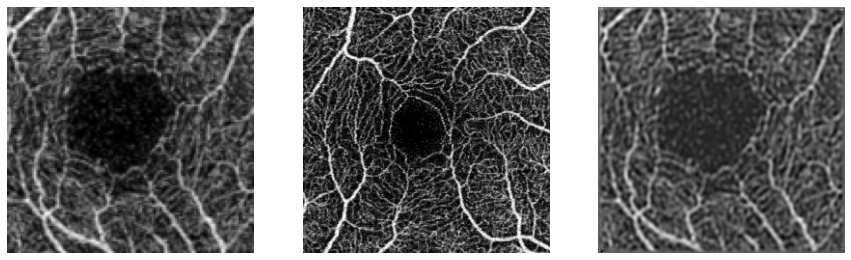

In [27]:
plt.figure(figsize=(15, 15))
plt.subplot(131), plt.imshow(img[0], "gray")
plt.axis('off')
plt.subplot(132),plt.imshow(gt.squeeze(0), "gray")
plt.axis('off')
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.subplot(133), plt.imshow(yimg, "gray")
plt.axis('off')

ours_whole = yimg

(-0.5, 255.5, 255.5, -0.5)

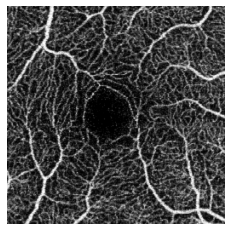

In [29]:
img = test_dataset[69]['B']
x = torch.tensor(img).unsqueeze(0).cuda()
plt.imshow(img[0], "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

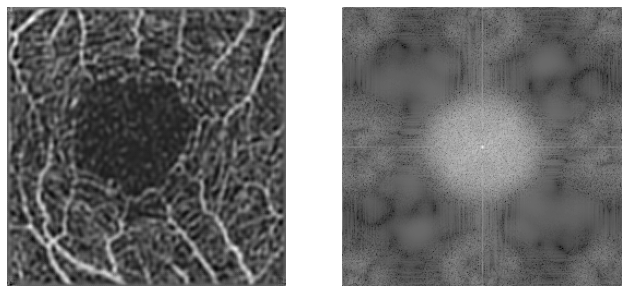

In [30]:
f = np.fft.fft2(yimg, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(yimg, 'gray')
plt.axis('off')
plt.subplot(122), plt.imshow(res, 'gray')
plt.axis('off')

(-0.5, 127.5, 127.5, -0.5)

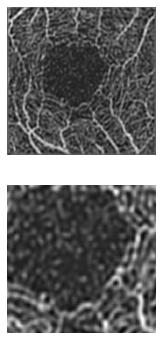

In [31]:
plt.figure(figsize=(6, 6))
plt.subplot(211), plt.imshow(ours_whole, "gray")
plt.axis('off')
plt.subplot(212), plt.imshow(ours_whole[64:192, 64:192], "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

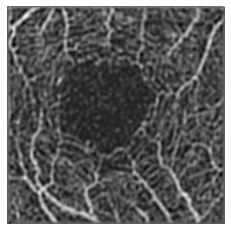

In [32]:
plt.imshow(ours_whole, "gray")
plt.axis('off')

Pick a pair of test data to evaluate

In [ ]:
netG_A2B = torch.load('./baseline_output_resnet/netG_A2B_epoch100.pth')
type(netG_A2B)
model = ResnetGenerator(output_nc, input_nc).cuda()
model.load_state_dict(netG_A2B, strict=False)

In [ ]:
lr_img = Image.open("./test/6x6_256/270_3.png").convert('L')
hr_img = Image.open("./test/3x3_256/270_6.png").convert('L')
# lr_img = Image.open("./dataset/Colab_centered_OCTA/trainA/STDR403_20181029_101618_Angio (1)_R_001.png").convert('L')
# hr_img = Image.open("./dataset/Colab_centered_OCTA/trainB/STDR403_20181029_101802_Angio (1)_R_001.png").convert('L')
T_1 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                 ])
T_2 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))])
# lr_img = cv2.resize(np.array(lr_img), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
# lr_img = torch.tensor(lr_img).unsqueeze(0).unsqueeze(0).cuda()
lr_img = T_1(lr_img).cuda().unsqueeze(0)
hr_img = T_2(hr_img).cuda().unsqueeze(0)
# lr_img.size()
sr_img = model(lr_img)

In [ ]:
ximg = lr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
print(ximg.shape)
plt.imshow(ximg, "gray")

In [ ]:
yimg = sr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")

In [ ]:
gtimg = hr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(gtimg, "gray")

In [ ]:
import skimage.metrics
print(skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
print(skimage.metrics.structural_similarity(yimg, gtimg))

# Result

In [ ]:
import skimage.metrics
print(skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
print(skimage.metrics.structural_similarity(yimg, gtimg))

In [ ]:
lr_img = Image.open("./test/6x6_256/270_3.png").convert('L')
hr_img = Image.open("./test/3x3_256/270_6.png").convert('L')
lr_img = T_1(lr_img)
hr_img = T_2(hr_img)

In [ ]:
input = lr_img.cuda().unsqueeze(0)
output = model(input)
# output = output.cpu().detach().numpy().squeeze(0).squeeze(0)